# Лабораторная работа 3: Статистический анализ имитационной модели

**Цель:** Для стационарного состояния имитационной модели сложной системы (билетные кассы на автовокзале из ЛР2) провести статистический анализ по двум откликам:
- Среднее время ожидания в очереди (avg_wait_time)
- Среднее время пребывания в системе (avg_system_time)

**Задачи:**
1. Используя критерий хи-квадрат, проверить гипотезу о нормальности распределения откликов при «длинных» повторных прогонах
2. Вычислить точечные и интервальные оценки откликов ИМ в опыте из 20 повторных прогонов при уровне значимости 0.05
3. Оценить зависимость точности имитации от количества прогонов и определить, при каком количестве прогонов достигается 5% погрешность отклика
4. Построить зависимость изменения отклика в модельном времени, выдвинуть и проверить гипотезу об уменьшении времени прогона, исключая переходный период
5. Проверить гипотезу о возможности постановки опыта с непрерывным прогоном
6. Оценить чувствительность откликов к вариациям переменных ИМ, используя опыт с непрерывным прогоном (определить достаточную точность задания переменной)


In [ ]:
# Импорт необходимых библиотек
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Dict, Tuple, Any
import heapq
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2, normaltest, shapiro, t, ttest_ind, ttest_1samp
import warnings
warnings.filterwarnings('ignore')

# Настройка matplotlib для русского языка
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 6)

# Функция для корректного отображения p-value
def format_pvalue(p_value):
    """Форматирует p-value для читаемого вывода"""
    if p_value < 0.0001:
        return f"{p_value:.2e} (< 0.0001)"
    elif p_value < 0.001:
        return f"{p_value:.6f}"
    else:
        return f"{p_value:.4f}"


In [3]:
# Копирование кода модели из Lab2
SEED = 42
random.seed(SEED)

MINUTES = 1.0
HOUR = 60.0 * MINUTES

PARAMS = {
    "arrival_rate": 1.0,
    "service_rate_per_booth": 0.35,
    "num_booths": 4,
    "work_minutes": 45.0,
    "break_minutes": 15.0,
    "announce_minutes": 5.0,
    "simulation_duration": 8 * HOUR,
    "approx_delta": 1,
    "epsilon_random": 0.05,
    "announce_migrate_prob": 1.0,
    "announce_penalty": 2,
    "max_wait_time": None,
}

@dataclass
class Passenger:
    id: int
    arrival_time: float
    chosen_booth_id: Optional[int] = None
    service_start_time: Optional[float] = None
    service_end_time: Optional[float] = None
    abandoned: bool = False
    waited_over_break: bool = False

@dataclass(order=True)
class Event:
    time: float
    priority: int
    kind: str
    payload: Any = field(compare=False, default=None)

class DES:
    def __init__(self):
        self.t: float = 0.0
        self.queue: List[Event] = []
        self.event_counter: int = 0

    def schedule(self, time: float, kind: str, payload: Any = None, priority: int = 0):
        self.event_counter += 1
        evt = Event(time=time, priority=priority, kind=kind, payload=payload)
        heapq.heappush(self.queue, evt)

    def run(self, until: float, on_event: Callable[[Event, float], None]):
        while self.queue and self.queue[0].time <= until:
            evt = heapq.heappop(self.queue)
            self.t = evt.time
            on_event(evt, self.t)
        self.t = until

class TicketBooth:
    def __init__(self, booth_id: int, params: Dict[str, Any]):
        self.booth_id = booth_id
        self.params = params
        self.queue: List[Passenger] = []
        self.is_on_break: bool = False
        self.is_in_announce: bool = False
        self.cycle_start_time: float = 0.0
        self.currently_serving: Optional[Passenger] = None
        self.next_cycle_break_start: float = 0.0
        self.next_cycle_break_end: float = 0.0
        self.next_announce_time: float = 0.0

    def perceived_queue_length(self) -> int:
        penalty = self.params["announce_penalty"] if self.is_in_announce else 0
        if self.is_on_break:
            return 10**9
        return len(self.queue) + penalty

    def plan_cycle(self, now: float) -> Tuple[float, float, float]:
        work = self.params["work_minutes"]
        brk = self.params["break_minutes"]
        announce = self.params["announce_minutes"]
        start = now
        break_start = start + work
        break_end = break_start + brk
        announce_time = max(start, break_start - announce)
        self.cycle_start_time = start
        self.next_cycle_break_start = break_start
        self.next_cycle_break_end = break_end
        self.next_announce_time = announce_time
        return announce_time, break_start, break_end

    def on_announce(self):
        self.is_in_announce = True

    def on_break_start(self):
        self.is_on_break = True
        self.is_in_announce = False

    def on_break_end(self, new_cycle_start: float):
        self.is_on_break = False
        self.is_in_announce = False
        self.cycle_start_time = new_cycle_start

class Metrics:
    def __init__(self, num_booths: int):
        self.num_booths = num_booths
        self.total_wait_time: float = 0.0
        self.total_system_time: float = 0.0
        self.num_completed: int = 0
        self.num_abandoned: int = 0
        self.num_waited_over_break: int = 0
        self.queue_area: List[float] = [0.0 for _ in range(num_booths)]
        self.last_queue_time: float = 0.0

    def accumulate_queue_lengths(self, booths: List[TicketBooth], now: float):
        dt = now - self.last_queue_time
        if dt < 0:
            return
        for i, booth in enumerate(booths):
            self.queue_area[i] += len(booth.queue) * dt
        self.last_queue_time = now

    def record_service_completion(self, p: Passenger):
        if p.service_start_time is not None:
            self.total_wait_time += (p.service_start_time - p.arrival_time)
        if p.service_end_time is not None:
            self.total_system_time += (p.service_end_time - p.arrival_time)
        self.num_completed += 1

    def record_abandon(self):
        self.num_abandoned += 1

    def record_waited_over_break(self):
        self.num_waited_over_break += 1

def expovariate(rate: float) -> float:
    u = random.random()
    return -math.log(1.0 - u) / rate

class BusStationModel:
    def __init__(self, params: Dict[str, Any]):
        self.params = params
        self.des = DES()
        self.booths: List[TicketBooth] = [TicketBooth(i, params) for i in range(params["num_booths"])]
        self.metrics = Metrics(params["num_booths"])
        self.now = 0.0
        self.next_passenger_id = 0

    def initialize(self):
        self.now = 0.0
        self.metrics.last_queue_time = 0.0
        for booth in self.booths:
            announce_time, break_start, break_end = booth.plan_cycle(self.now)
            self.des.schedule(announce_time, kind="announce", payload={"booth": booth.booth_id})
            self.des.schedule(break_start, kind="break_start", payload={"booth": booth.booth_id})
            self.des.schedule(break_end, kind="break_end", payload={"booth": booth.booth_id})
        ia = expovariate(self.params["arrival_rate"]) if self.params["arrival_rate"] > 0 else float("inf")
        self.des.schedule(self.now + ia, kind="arrival")

    def choose_booth_for_passenger(self) -> int:
        delta = self.params["approx_delta"]
        epsilon = self.params["epsilon_random"]
        perceived = [(booth.perceived_queue_length(), booth.booth_id) for booth in self.booths]
        perceived.sort()
        min_len = perceived[0][0]
        candidates = [bid for (l, bid) in perceived if l <= min_len + delta]
        if random.random() < epsilon:
            return random.choice([b.booth_id for b in self.booths])
        return random.choice(candidates)

    def handle_event(self, evt: Event, now: float):
        self.metrics.accumulate_queue_lengths(self.booths, now)
        self.now = now
        kind = evt.kind
        payload = evt.payload or {}
        if kind == "arrival":
            self.on_arrival()
        elif kind == "service_end":
            self.on_service_end(payload["booth"], payload["passenger"]) 
        elif kind == "announce":
            self.on_announce(payload["booth"]) 
        elif kind == "break_start":
            self.on_break_start(payload["booth"]) 
        elif kind == "break_end":
            self.on_break_end(payload["booth"])

    def on_arrival(self):
        p = Passenger(id=self.next_passenger_id, arrival_time=self.now)
        self.next_passenger_id += 1
        booth_id = self.choose_booth_for_passenger()
        p.chosen_booth_id = booth_id
        booth = self.booths[booth_id]
        max_wait = self.params["max_wait_time"]
        if max_wait is not None and booth.is_on_break:
            time_until_end = booth.next_cycle_break_end - self.now
            if time_until_end > max_wait:
                p.abandoned = True
                self.metrics.record_abandon()
            else:
                booth.queue.append(p)
        else:
            booth.queue.append(p)
        if not booth.is_on_break and booth.currently_serving is None and booth.queue:
            self.start_service(booth)
        ia = expovariate(self.params["arrival_rate"]) if self.params["arrival_rate"] > 0 else float("inf")
        next_t = self.now + ia
        if next_t <= self.params["simulation_duration"]:
            self.des.schedule(next_t, kind="arrival")

    def start_service(self, booth: TicketBooth):
        if booth.is_on_break or not booth.queue:
            return
        p = booth.queue.pop(0)
        booth.currently_serving = p
        p.service_start_time = self.now
        service_time = expovariate(self.params["service_rate_per_booth"]) if self.params["service_rate_per_booth"] > 0 else float("inf")
        end_time = self.now + service_time
        if end_time > booth.next_cycle_break_start and not booth.is_on_break:
            time_before_break = booth.next_cycle_break_start - self.now
            remaining = service_time - max(0.0, time_before_break)
            p.waited_over_break = True
            self.metrics.record_waited_over_break()
            end_time = booth.next_cycle_break_end + remaining
        self.des.schedule(end_time, kind="service_end", payload={"booth": booth.booth_id, "passenger": p})

    def on_service_end(self, booth_id: int, p: Passenger):
        booth = self.booths[booth_id]
        booth.currently_serving = None
        p.service_end_time = self.now
        self.metrics.record_service_completion(p)
        if not booth.is_on_break and booth.queue:
            self.start_service(booth)

    def on_announce(self, booth_id: int):
        booth = self.booths[booth_id]
        booth.on_announce()
        migrate_prob = self.params["announce_migrate_prob"]
        if migrate_prob <= 0 or not booth.queue:
            return
        remaining_queue = []
        for p in booth.queue:
            if random.random() < migrate_prob:
                new_booth_id = self.choose_booth_for_passenger()
                if new_booth_id != booth_id:
                    self.booths[new_booth_id].queue.append(p)
                    continue
            remaining_queue.append(p)
        booth.queue = remaining_queue
        if not booth.is_on_break and booth.currently_serving is None and booth.queue:
            self.start_service(booth)

    def on_break_start(self, booth_id: int):
        booth = self.booths[booth_id]
        booth.on_break_start()

    def on_break_end(self, booth_id: int):
        booth = self.booths[booth_id]
        booth.on_break_end(new_cycle_start=self.now)
        announce_time, break_start, break_end = booth.plan_cycle(self.now)
        self.des.schedule(announce_time, kind="announce", payload={"booth": booth.booth_id})
        self.des.schedule(break_start, kind="break_start", payload={"booth": booth.booth_id})
        self.des.schedule(break_end, kind="break_end", payload={"booth": booth.booth_id})
        if booth.queue and booth.currently_serving is None:
            self.start_service(booth)

    def run(self):
        self.initialize()
        self.des.run(until=self.params["simulation_duration"], on_event=self.handle_event)
        self.metrics.accumulate_queue_lengths(self.booths, self.params["simulation_duration"])

def compute_results(model: BusStationModel):
    m = model.metrics
    sim_time = model.params["simulation_duration"]
    avg_wait = (m.total_wait_time / m.num_completed) if m.num_completed > 0 else 0.0
    avg_system = (m.total_system_time / m.num_completed) if m.num_completed > 0 else 0.0
    avg_queue_lengths = [area / sim_time for area in m.queue_area]
    return {
        "avg_wait_time": avg_wait,
        "avg_system_time": avg_system,
        "avg_queue_lengths": avg_queue_lengths,
        "num_waited_over_break": m.num_waited_over_break,
        "num_completed": m.num_completed,
        "num_abandoned": m.num_abandoned,
    }

def run_replications(n: int, params: Dict[str, Any], seed: int = SEED) -> Tuple[list, list]:
    results = []
    models = []
    for i in range(n):
        random.seed(seed + i)
        m = BusStationModel(params)
        m.run()
        res = compute_results(m)
        results.append(res)
        models.append(m)
    return results, models

print("Модель загружена успешно")


Модель загружена успешно


## Задача 1: Проверка нормальности распределения откликов (критерий хи-квадрат)

Проведем "длинные" повторные прогоны (100 прогонов) и проверим гипотезу о нормальности распределения откликов с помощью критерия хи-квадрат.


In [ ]:
# Задача 1: Проверка нормальности распределения откликов (критерий хи-квадрат)

def chi_square_normality_test(data, num_bins=10, alpha=0.05):
    """
    Проверка нормальности с помощью критерия хи-квадрат
    """
    n = len(data)
    mean_data = np.mean(data)
    std_data = np.std(data, ddof=1)
    
    # Разбиваем данные на интервалы
    hist, bin_edges = np.histogram(data, bins=num_bins)
    
    # Вычисляем ожидаемые частоты для нормального распределения
    expected_freq = []
    for i in range(len(bin_edges) - 1):
        # Вероятность попадания в интервал
        prob = stats.norm.cdf(bin_edges[i+1], mean_data, std_data) - \
               stats.norm.cdf(bin_edges[i], mean_data, std_data)
        expected_freq.append(prob * n)
    
    # Объединяем интервалы с малыми ожидаемыми частотами (< 5)
    observed = []
    expected = []
    for i in range(len(hist)):
        if expected_freq[i] >= 5:
            observed.append(hist[i])
            expected.append(expected_freq[i])
        else:
            # Объединяем с соседним
            if i < len(hist) - 1:
                hist[i+1] += hist[i]
                expected_freq[i+1] += expected_freq[i]
    
    # Вычисляем статистику хи-квадрат
    chi2_stat = sum((obs - exp)**2 / exp for obs, exp in zip(observed, expected) if exp > 0)
    df = len(observed) - 3  # -3 из-за оценки среднего, дисперсии и объединения интервалов
    df = max(1, df)  # минимум 1 степень свободы
    
    p_value = 1 - chi2.cdf(chi2_stat, df)
    critical_value = chi2.ppf(1 - alpha, df)
    
    return {
        'chi2_statistic': chi2_stat,
        'degrees_of_freedom': df,
        'p_value': p_value,
        'critical_value': critical_value,
        'reject_null': chi2_stat > critical_value
    }

# Выполняем длинные прогоны (100 прогонов)
print("Выполняем 100 прогонов для проверки нормальности...")
N_LONG = 100
results_long, _ = run_replications(N_LONG, PARAMS, seed=SEED)

# Извлекаем отклики
wait_times = [r['avg_wait_time'] for r in results_long]
system_times = [r['avg_system_time'] for r in results_long]

print(f"\nСреднее время ожидания: {np.mean(wait_times):.4f} ± {np.std(wait_times, ddof=1):.4f}")
print(f"Среднее время пребывания: {np.mean(system_times):.4f} ± {np.std(system_times, ddof=1):.4f}")

# Проверка нормальности для времени ожидания
print("\n" + "="*60)
print("Проверка нормальности: Среднее время ожидания в очереди")
print("="*60)
test_wait = chi_square_normality_test(wait_times, num_bins=10, alpha=0.05)
print(f"Статистика хи-квадрат: {test_wait['chi2_statistic']:.4f}")
print(f"Степени свободы: {test_wait['degrees_of_freedom']}")
print(f"Критическое значение (α=0.05): {test_wait['critical_value']:.4f}")
print(f"p-value: {format_pvalue(test_wait['p_value'])}")
print(f"Гипотеза о нормальности: {'ОТВЕРГНУТА' if test_wait['reject_null'] else 'ПРИНЯТА'}")

# Проверка нормальности для времени пребывания
print("\n" + "="*60)
print("Проверка нормальности: Среднее время пребывания в системе")
print("="*60)
test_system = chi_square_normality_test(system_times, num_bins=10, alpha=0.05)
print(f"Статистика хи-квадрат: {test_system['chi2_statistic']:.4f}")
print(f"Степени свободы: {test_system['degrees_of_freedom']}")
print(f"Критическое значение (α=0.05): {test_system['critical_value']:.4f}")
print(f"p-value: {format_pvalue(test_system['p_value'])}")
print(f"Гипотеза о нормальности: {'ОТВЕРГНУТА' if test_system['reject_null'] else 'ПРИНЯТА'}")

# Дополнительные тесты нормальности
print("\n" + "="*60)
print("Дополнительные тесты нормальности (Shapiro-Wilk, D'Agostino)")
print("="*60)

# Shapiro-Wilk (для малых выборок, но попробуем)
if len(wait_times) <= 5000:
    shapiro_wait = shapiro(wait_times)
    shapiro_system = shapiro(system_times)
    print(f"\nShapiro-Wilk для времени ожидания:")
    print(f"  Статистика: {shapiro_wait.statistic:.4f}, p-value: {format_pvalue(shapiro_wait.pvalue)}")
    print(f"Shapiro-Wilk для времени пребывания:")
    print(f"  Статистика: {shapiro_system.statistic:.4f}, p-value: {format_pvalue(shapiro_system.pvalue)}")

# D'Agostino's normality test
dagostino_wait = normaltest(wait_times)
dagostino_system = normaltest(system_times)
print(f"\nD'Agostino для времени ожидания:")
print(f"  Статистика: {dagostino_wait.statistic:.4f}, p-value: {format_pvalue(dagostino_wait.pvalue)}")
print(f"D'Agostino для времени пребывания:")
print(f"  Статистика: {dagostino_system.statistic:.4f}, p-value: {format_pvalue(dagostino_system.pvalue)}")


Выполняем 100 прогонов для проверки нормальности...

Среднее время ожидания: 14.3267 ± 6.0918
Среднее время пребывания: 17.9296 ± 6.2284

Проверка нормальности: Среднее время ожидания в очереди
Статистика хи-квадрат: 37.4156
Степени свободы: 3
Критическое значение (α=0.05): 7.8147
p-value: 0.0000
Гипотеза о нормальности: ОТВЕРГНУТА

Проверка нормальности: Среднее время пребывания в системе
Статистика хи-квадрат: 29.1796
Степени свободы: 3
Критическое значение (α=0.05): 7.8147
p-value: 0.0000
Гипотеза о нормальности: ОТВЕРГНУТА

Дополнительные тесты нормальности (Shapiro-Wilk, D'Agostino)

Shapiro-Wilk для времени ожидания:
  Статистика: 0.8341, p-value: 0.0000
Shapiro-Wilk для времени пребывания:
  Статистика: 0.8409, p-value: 0.0000

D'Agostino для времени ожидания:
  Статистика: 43.7865, p-value: 0.0000
D'Agostino для времени пребывания:
  Статистика: 42.5673, p-value: 0.0000


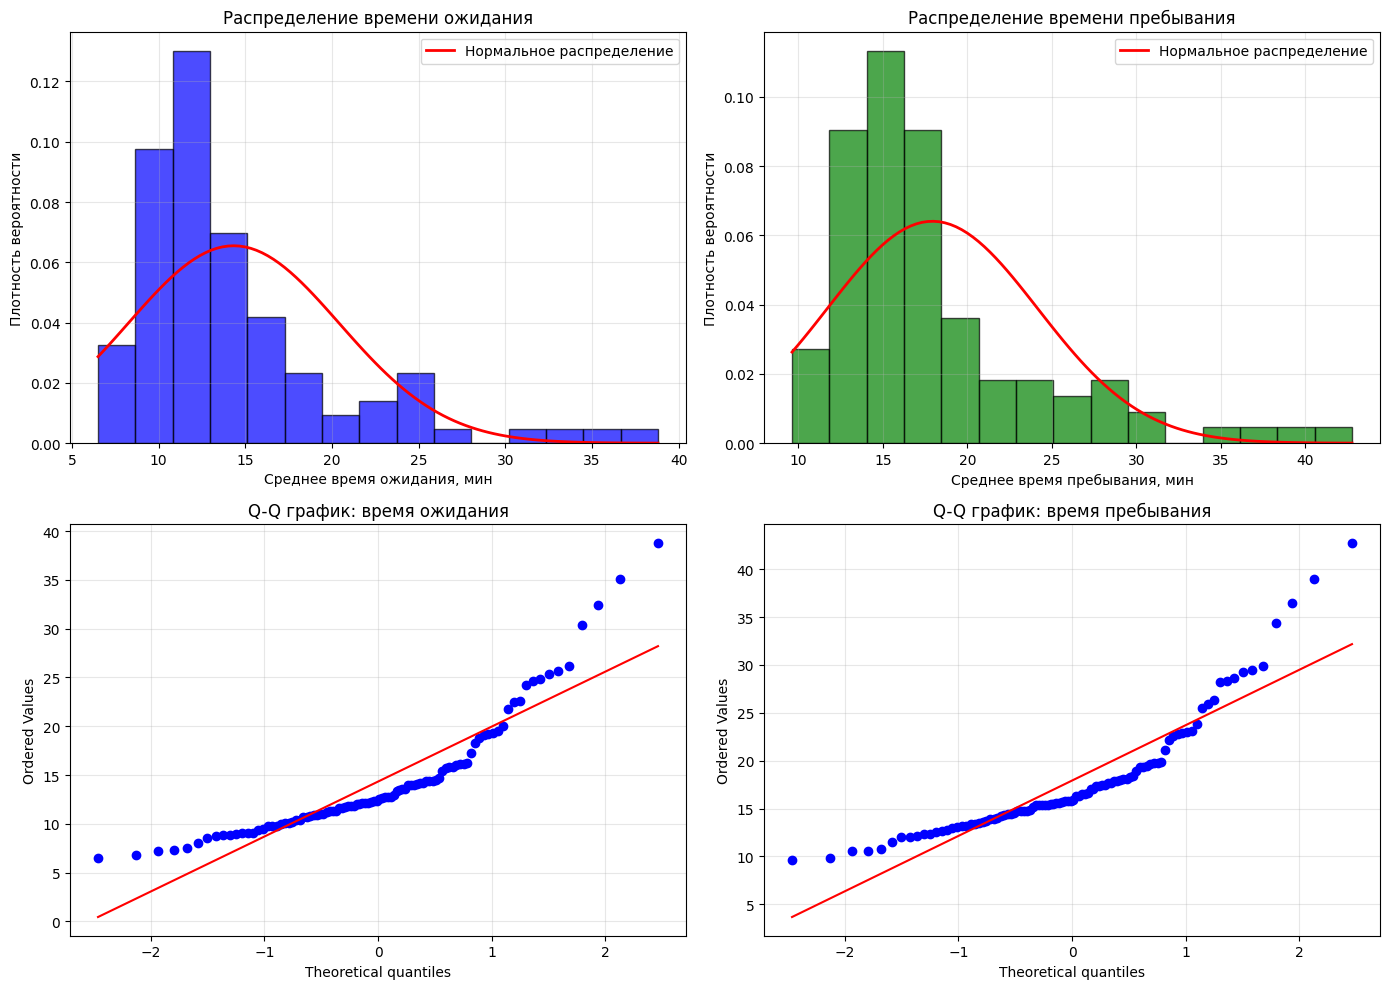

In [12]:
# Визуализация распределений откликов
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Гистограммы с наложенными нормальными распределениями
axes[0, 0].hist(wait_times, bins=15, density=True, alpha=0.7, color='blue', edgecolor='black')
x_wait = np.linspace(np.min(wait_times), np.max(wait_times), 100)
axes[0, 0].plot(x_wait, stats.norm.pdf(x_wait, np.mean(wait_times), np.std(wait_times, ddof=1)), 
                'r-', linewidth=2, label='Нормальное распределение')
axes[0, 0].set_xlabel('Среднее время ожидания, мин')
axes[0, 0].set_ylabel('Плотность вероятности')
axes[0, 0].set_title('Распределение времени ожидания')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(system_times, bins=15, density=True, alpha=0.7, color='green', edgecolor='black')
x_system = np.linspace(np.min(system_times), np.max(system_times), 100)
axes[0, 1].plot(x_system, stats.norm.pdf(x_system, np.mean(system_times), np.std(system_times, ddof=1)), 
                'r-', linewidth=2, label='Нормальное распределение')
axes[0, 1].set_xlabel('Среднее время пребывания, мин')
axes[0, 1].set_ylabel('Плотность вероятности')
axes[0, 1].set_title('Распределение времени пребывания')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plots
stats.probplot(wait_times, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q график: время ожидания')
axes[1, 0].grid(True, alpha=0.3)

stats.probplot(system_times, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q график: время пребывания')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Задача 2: Точечные и интервальные оценки откликов (20 прогонов, α=0.05)

Вычислим точечные оценки (среднее) и интервальные оценки (доверительные интервалы) для откликов на основе 20 повторных прогонов.


Выполняем 20 повторных прогонов...

ТОЧЕЧНЫЕ И ИНТЕРВАЛЬНЫЕ ОЦЕНКИ (20 прогонов, α=0.05)

1. Среднее время ожидания в очереди:
   Точечная оценка (среднее): 14.2671 мин
   Стандартное отклонение: 5.8836 мин
   Стандартная ошибка: 1.3156 мин
   Доверительный интервал (95%): [11.5135, 17.0207] мин
   Ширина интервала: 5.5072 мин
   Относительная погрешность: 19.30%

2. Среднее время пребывания в системе:
   Точечная оценка (среднее): 17.9094 мин
   Стандартное отклонение: 6.0305 мин
   Стандартная ошибка: 1.3485 мин
   Доверительный интервал (95%): [15.0870, 20.7317] мин
   Ширина интервала: 5.6448 мин
   Относительная погрешность: 15.76%


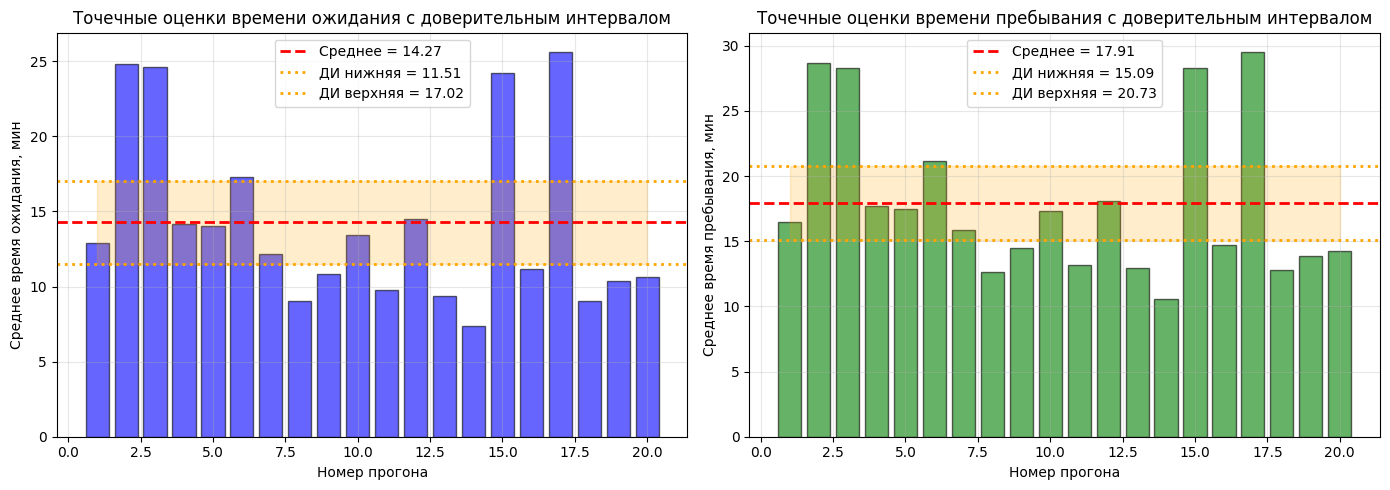

In [14]:
# Задача 2: Точечные и интервальные оценки откликов (20 прогонов, α=0.05)

N_REPS = 20
alpha = 0.05

print(f"Выполняем {N_REPS} повторных прогонов...")
results_20, _ = run_replications(N_REPS, PARAMS, seed=SEED)

wait_20 = [r['avg_wait_time'] for r in results_20]
system_20 = [r['avg_system_time'] for r in results_20]

# Точечные оценки
mean_wait = np.mean(wait_20)
mean_system = np.mean(system_20)
std_wait = np.std(wait_20, ddof=1)
std_system = np.std(system_20, ddof=1)

# Интервальные оценки (t-распределение для малой выборки)
from scipy.stats import t
t_critical = t.ppf(1 - alpha/2, N_REPS - 1)

# Стандартная ошибка среднего
se_wait = std_wait / np.sqrt(N_REPS)
se_system = std_system / np.sqrt(N_REPS)

# Доверительные интервалы
ci_wait_lower = mean_wait - t_critical * se_wait
ci_wait_upper = mean_wait + t_critical * se_wait
ci_system_lower = mean_system - t_critical * se_system
ci_system_upper = mean_system + t_critical * se_system

print("\n" + "="*70)
print("ТОЧЕЧНЫЕ И ИНТЕРВАЛЬНЫЕ ОЦЕНКИ (20 прогонов, α=0.05)")
print("="*70)

print(f"\n1. Среднее время ожидания в очереди:")
print(f"   Точечная оценка (среднее): {mean_wait:.4f} мин")
print(f"   Стандартное отклонение: {std_wait:.4f} мин")
print(f"   Стандартная ошибка: {se_wait:.4f} мин")
print(f"   Доверительный интервал (95%): [{ci_wait_lower:.4f}, {ci_wait_upper:.4f}] мин")
print(f"   Ширина интервала: {ci_wait_upper - ci_wait_lower:.4f} мин")
print(f"   Относительная погрешность: {(t_critical * se_wait / mean_wait * 100):.2f}%")

print(f"\n2. Среднее время пребывания в системе:")
print(f"   Точечная оценка (среднее): {mean_system:.4f} мин")
print(f"   Стандартное отклонение: {std_system:.4f} мин")
print(f"   Стандартная ошибка: {se_system:.4f} мин")
print(f"   Доверительный интервал (95%): [{ci_system_lower:.4f}, {ci_system_upper:.4f}] мин")
print(f"   Ширина интервала: {ci_system_upper - ci_system_lower:.4f} мин")
print(f"   Относительная погрешность: {(t_critical * se_system / mean_system * 100):.2f}%")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Время ожидания
axes[0].bar(range(1, N_REPS + 1), wait_20, alpha=0.6, color='blue', edgecolor='black')
axes[0].axhline(mean_wait, color='red', linestyle='--', linewidth=2, label=f'Среднее = {mean_wait:.2f}')
axes[0].axhline(ci_wait_lower, color='orange', linestyle=':', linewidth=2, label=f'ДИ нижняя = {ci_wait_lower:.2f}')
axes[0].axhline(ci_wait_upper, color='orange', linestyle=':', linewidth=2, label=f'ДИ верхняя = {ci_wait_upper:.2f}')
axes[0].fill_between(range(1, N_REPS + 1), ci_wait_lower, ci_wait_upper, alpha=0.2, color='orange')
axes[0].set_xlabel('Номер прогона')
axes[0].set_ylabel('Среднее время ожидания, мин')
axes[0].set_title('Точечные оценки времени ожидания с доверительным интервалом')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Время пребывания
axes[1].bar(range(1, N_REPS + 1), system_20, alpha=0.6, color='green', edgecolor='black')
axes[1].axhline(mean_system, color='red', linestyle='--', linewidth=2, label=f'Среднее = {mean_system:.2f}')
axes[1].axhline(ci_system_lower, color='orange', linestyle=':', linewidth=2, label=f'ДИ нижняя = {ci_system_lower:.2f}')
axes[1].axhline(ci_system_upper, color='orange', linestyle=':', linewidth=2, label=f'ДИ верхняя = {ci_system_upper:.2f}')
axes[1].fill_between(range(1, N_REPS + 1), ci_system_lower, ci_system_upper, alpha=0.2, color='orange')
axes[1].set_xlabel('Номер прогона')
axes[1].set_ylabel('Среднее время пребывания, мин')
axes[1].set_title('Точечные оценки времени пребывания с доверительным интервалом')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Задача 3: Зависимость точности от количества прогонов

Оценим зависимость точности имитации от количества прогонов и определим, при каком количестве прогонов достигается 5% погрешность отклика.


Анализ зависимости точности от количества прогонов...
Выполняем прогоны для разных N...

РЕЗУЛЬТАТЫ АНАЛИЗА ТОЧНОСТИ

Для достижения 5% погрешности:
  Время ожидания: требуется более 100 прогонов (при 100 прогонах: 8.44%)
  Время пребывания: требуется более 100 прогонов (при 100 прогонах: 6.89%)


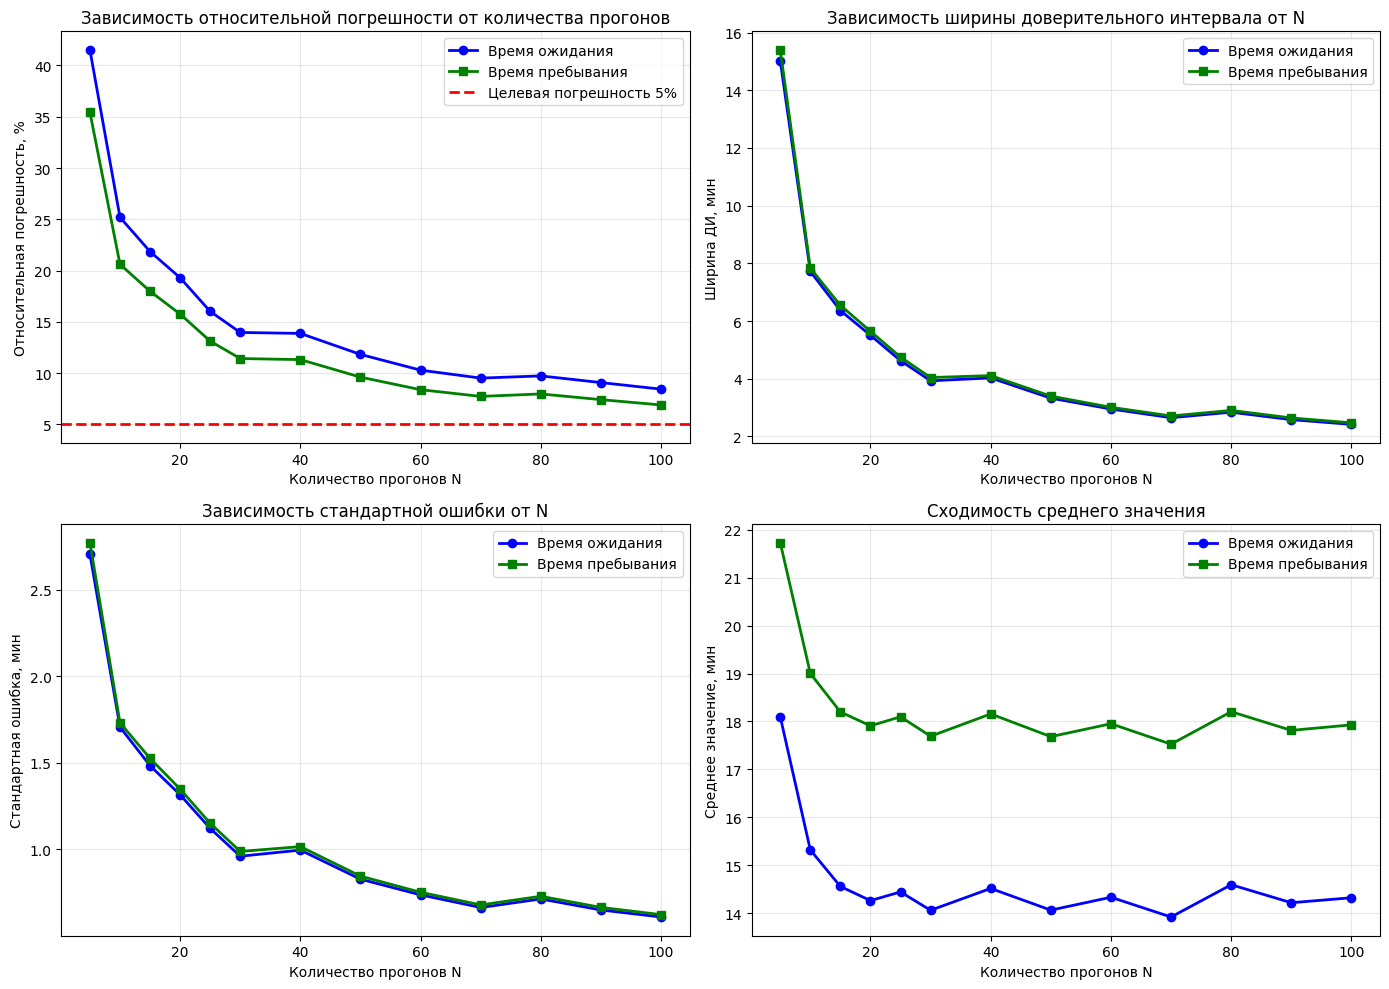


ТАБЛИЦА ЗАВИСИМОСТИ ТОЧНОСТИ ОТ КОЛИЧЕСТВА ПРОГОНОВ
N      Отн. погр. ожид., %  Отн. погр. преб., %  Ширина ДИ ожид.    Ширина ДИ преб.   
----------------------------------------------------------------------
5      41.51                35.43                15.0245            15.3954           
10     25.19                20.61                7.7212             7.8325            
15     21.85                17.98                6.3651             6.5450            
20     19.30                15.76                5.5072             5.6448            
25     16.02                13.12                4.6285             4.7500            
30     13.97                11.42                3.9286             4.0413            
40     13.87                11.32                4.0287             4.1097            
50     11.82                9.61                 3.3268             3.3977            
60     10.29                8.38                 2.9501             3.0095            
70    

In [16]:
# Задача 3: Зависимость точности от количества прогонов

# Выполняем прогоны с разным количеством повторений
max_n = 100
n_values = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

print("Анализ зависимости точности от количества прогонов...")
print("Выполняем прогоны для разных N...")

# Выполняем все прогоны один раз
all_results, _ = run_replications(max_n, PARAMS, seed=SEED)
all_wait = [r['avg_wait_time'] for r in all_results]
all_system = [r['avg_system_time'] for r in all_results]

# Для каждого N вычисляем статистики
relative_errors_wait = []
relative_errors_system = []
mean_values_wait = []
mean_values_system = []
ci_widths_wait = []
ci_widths_system = []

for n in n_values:
    wait_n = all_wait[:n]
    system_n = all_system[:n]
    
    mean_w = np.mean(wait_n)
    mean_s = np.mean(system_n)
    std_w = np.std(wait_n, ddof=1)
    std_s = np.std(system_n, ddof=1)
    
    se_w = std_w / np.sqrt(n)
    se_s = std_s / np.sqrt(n)
    
    t_crit = t.ppf(1 - alpha/2, n - 1)
    
    # Относительная погрешность (полуширина ДИ / среднее)
    rel_err_w = (t_crit * se_w / mean_w * 100) if mean_w > 0 else 0
    rel_err_s = (t_crit * se_s / mean_s * 100) if mean_s > 0 else 0
    
    relative_errors_wait.append(rel_err_w)
    relative_errors_system.append(rel_err_s)
    mean_values_wait.append(mean_w)
    mean_values_system.append(mean_s)
    ci_widths_wait.append(2 * t_crit * se_w)
    ci_widths_system.append(2 * t_crit * se_s)

# Находим N для 5% погрешности
target_error = 5.0
n_for_5pct_wait = None
n_for_5pct_system = None

for i, n in enumerate(n_values):
    if relative_errors_wait[i] <= target_error and n_for_5pct_wait is None:
        n_for_5pct_wait = n
    if relative_errors_system[i] <= target_error and n_for_5pct_system is None:
        n_for_5pct_system = n

print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ АНАЛИЗА ТОЧНОСТИ")
print("="*70)
print(f"\nДля достижения 5% погрешности:")
if n_for_5pct_wait:
    print(f"  Время ожидания: требуется {n_for_5pct_wait} прогонов")
else:
    print(f"  Время ожидания: требуется более {max_n} прогонов (при {max_n} прогонах: {relative_errors_wait[-1]:.2f}%)")
if n_for_5pct_system:
    print(f"  Время пребывания: требуется {n_for_5pct_system} прогонов")
else:
    print(f"  Время пребывания: требуется более {max_n} прогонов (при {max_n} прогонах: {relative_errors_system[-1]:.2f}%)")

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Относительная погрешность
axes[0, 0].plot(n_values, relative_errors_wait, 'b-o', linewidth=2, markersize=6, label='Время ожидания')
axes[0, 0].plot(n_values, relative_errors_system, 'g-s', linewidth=2, markersize=6, label='Время пребывания')
axes[0, 0].axhline(5, color='r', linestyle='--', linewidth=2, label='Целевая погрешность 5%')
if n_for_5pct_wait:
    axes[0, 0].axvline(n_for_5pct_wait, color='b', linestyle=':', alpha=0.5)
if n_for_5pct_system:
    axes[0, 0].axvline(n_for_5pct_system, color='g', linestyle=':', alpha=0.5)
axes[0, 0].set_xlabel('Количество прогонов N')
axes[0, 0].set_ylabel('Относительная погрешность, %')
axes[0, 0].set_title('Зависимость относительной погрешности от количества прогонов')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Ширина доверительного интервала
axes[0, 1].plot(n_values, ci_widths_wait, 'b-o', linewidth=2, markersize=6, label='Время ожидания')
axes[0, 1].plot(n_values, ci_widths_system, 'g-s', linewidth=2, markersize=6, label='Время пребывания')
axes[0, 1].set_xlabel('Количество прогонов N')
axes[0, 1].set_ylabel('Ширина ДИ, мин')
axes[0, 1].set_title('Зависимость ширины доверительного интервала от N')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Стандартная ошибка
se_wait_list = [np.std(all_wait[:n], ddof=1) / np.sqrt(n) for n in n_values]
se_system_list = [np.std(all_system[:n], ddof=1) / np.sqrt(n) for n in n_values]
axes[1, 0].plot(n_values, se_wait_list, 'b-o', linewidth=2, markersize=6, label='Время ожидания')
axes[1, 0].plot(n_values, se_system_list, 'g-s', linewidth=2, markersize=6, label='Время пребывания')
axes[1, 0].set_xlabel('Количество прогонов N')
axes[1, 0].set_ylabel('Стандартная ошибка, мин')
axes[1, 0].set_title('Зависимость стандартной ошибки от N')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Сходимость среднего значения
axes[1, 1].plot(n_values, mean_values_wait, 'b-o', linewidth=2, markersize=6, label='Время ожидания')
axes[1, 1].plot(n_values, mean_values_system, 'g-s', linewidth=2, markersize=6, label='Время пребывания')
axes[1, 1].set_xlabel('Количество прогонов N')
axes[1, 1].set_ylabel('Среднее значение, мин')
axes[1, 1].set_title('Сходимость среднего значения')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Таблица результатов
print("\n" + "="*70)
print("ТАБЛИЦА ЗАВИСИМОСТИ ТОЧНОСТИ ОТ КОЛИЧЕСТВА ПРОГОНОВ")
print("="*70)
print(f"{'N':<6} {'Отн. погр. ожид., %':<20} {'Отн. погр. преб., %':<20} {'Ширина ДИ ожид.':<18} {'Ширина ДИ преб.':<18}")
print("-" * 70)
for i, n in enumerate(n_values):
    print(f"{n:<6} {relative_errors_wait[i]:<20.2f} {relative_errors_system[i]:<20.2f} "
          f"{ci_widths_wait[i]:<18.4f} {ci_widths_system[i]:<18.4f}")


Выполняем длинный прогон для анализа временных зависимостей...

АНАЛИЗ ПЕРЕХОДНОГО ПЕРИОДА
Переходный период: первые 50 завершенных обслуживаний

Время ожидания:
  Среднее в переходном периоде: 1.1098 мин
  Среднее в стационарном периоде: 17.8200 мин
  t-статистика: -17.3307, p-value: 0.0000
  Гипотеза о равенстве средних: ОТВЕРГНУТА

Время пребывания:
  Среднее в переходном периоде: 3.1941 мин
  Среднее в стационарном периоде: 21.5894 мин
  t-статистика: -18.3542, p-value: 0.0000
  Гипотеза о равенстве средних: ОТВЕРГНУТА


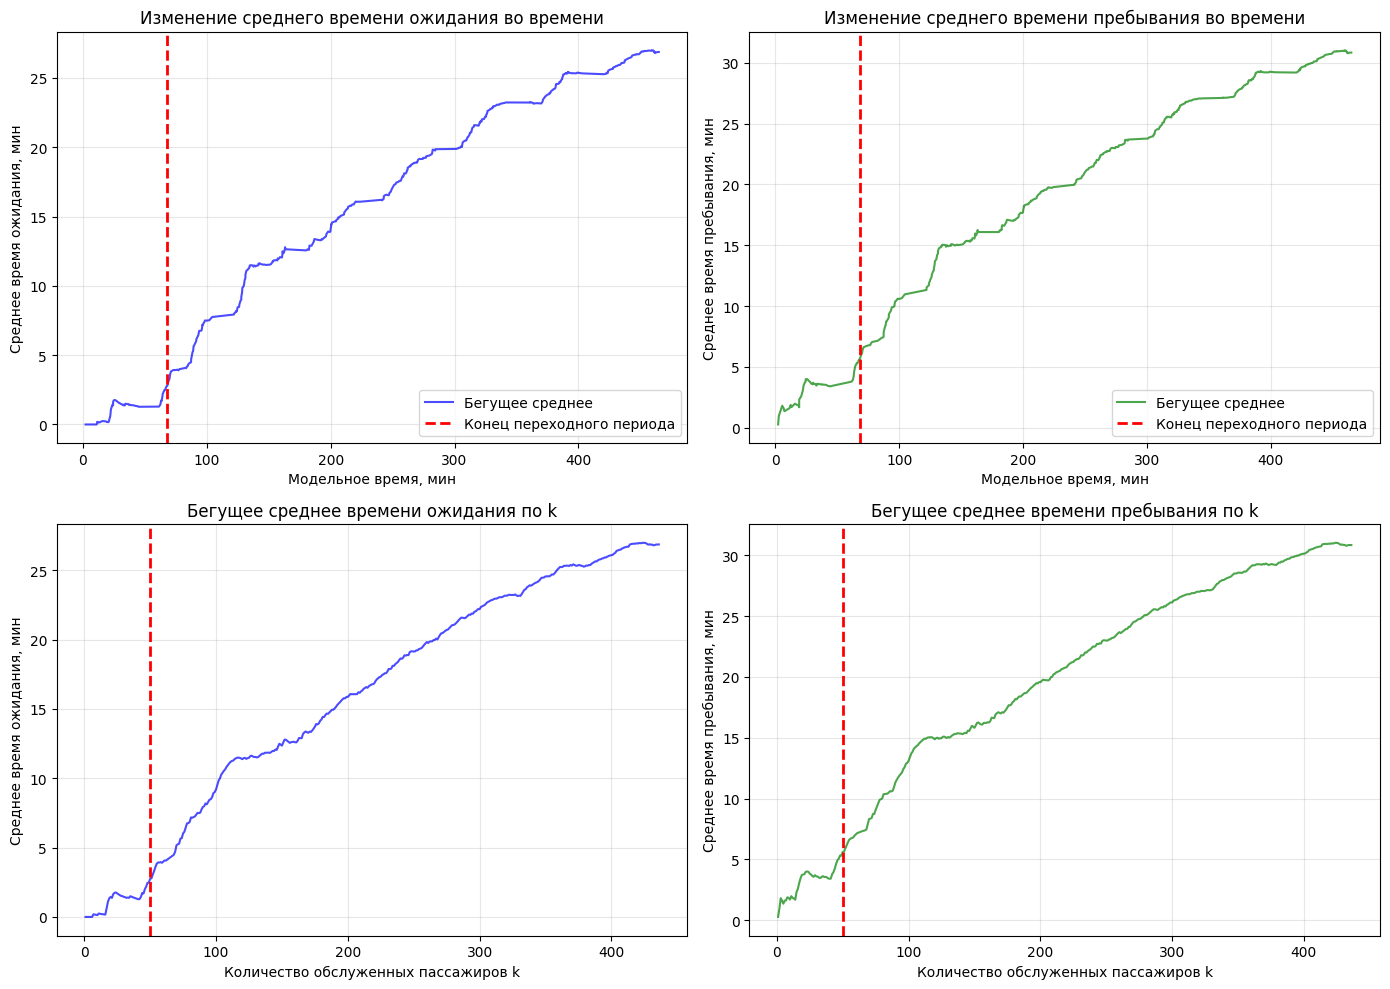


АНАЛИЗ ВОЗМОЖНОСТИ УМЕНЬШЕНИЯ ВРЕМЕНИ ПРОГОНА
Итоговое среднее (все данные): ожидание=26.8694, пребывание=30.8435
Среднее без переходного периода: ожидание=17.8200, пребывание=21.5894
Разница: ожидание=9.0494, пребывание=9.2540

Вывод: Переходный период существенен


In [ ]:
# Задача 4: Зависимость изменения отклика в модельном времени

# Модифицируем модель для отслеживания откликов во времени
class BusStationModelTimeSeries(BusStationModel):
    def __init__(self, params: Dict[str, Any]):
        super().__init__(params)
        self.wait_times_history: List[float] = []
        self.system_times_history: List[float] = []
        self.completion_times: List[float] = []
        self.passenger_wait_times: Dict[int, float] = {}
        self.passenger_arrival_times: Dict[int, float] = {}
        self.passenger_service_start_times: Dict[int, float] = {}
        
    def on_arrival(self):
        p = Passenger(id=self.next_passenger_id, arrival_time=self.now)
        self.next_passenger_id += 1
        self.passenger_arrival_times[p.id] = self.now
        booth_id = self.choose_booth_for_passenger()
        p.chosen_booth_id = booth_id
        booth = self.booths[booth_id]
        max_wait = self.params["max_wait_time"]
        if max_wait is not None and booth.is_on_break:
            time_until_end = booth.next_cycle_break_end - self.now
            if time_until_end > max_wait:
                p.abandoned = True
                self.metrics.record_abandon()
            else:
                booth.queue.append(p)
        else:
            booth.queue.append(p)
        if not booth.is_on_break and booth.currently_serving is None and booth.queue:
            self.start_service(booth)
        ia = expovariate(self.params["arrival_rate"]) if self.params["arrival_rate"] > 0 else float("inf")
        next_t = self.now + ia
        if next_t <= self.params["simulation_duration"]:
            self.des.schedule(next_t, kind="arrival")
    
    def start_service(self, booth: TicketBooth):
        if booth.is_on_break or not booth.queue:
            return
        p = booth.queue.pop(0)
        booth.currently_serving = p
        p.service_start_time = self.now
        self.passenger_service_start_times[p.id] = self.now
        service_time = expovariate(self.params["service_rate_per_booth"]) if self.params["service_rate_per_booth"] > 0 else float("inf")
        end_time = self.now + service_time
        if end_time > booth.next_cycle_break_start and not booth.is_on_break:
            time_before_break = booth.next_cycle_break_start - self.now
            remaining = service_time - max(0.0, time_before_break)
            p.waited_over_break = True
            self.metrics.record_waited_over_break()
            end_time = booth.next_cycle_break_end + remaining
        self.des.schedule(end_time, kind="service_end", payload={"booth": booth.booth_id, "passenger": p})
    
    def on_service_end(self, booth_id: int, p: Passenger):
        booth = self.booths[booth_id]
        booth.currently_serving = None
        p.service_end_time = self.now
        
        # Вычисляем времена ожидания и пребывания
        if p.id in self.passenger_arrival_times and p.id in self.passenger_service_start_times:
            wait_time = self.passenger_service_start_times[p.id] - self.passenger_arrival_times[p.id]
            system_time = self.now - self.passenger_arrival_times[p.id]
            
            self.wait_times_history.append(wait_time)
            self.system_times_history.append(system_time)
            self.completion_times.append(self.now)
        
        self.metrics.record_service_completion(p)
        if not booth.is_on_break and booth.queue:
            self.start_service(booth)

def compute_time_series_results(model: BusStationModelTimeSeries):
    """Вычисляет бегущие средние откликов во времени"""
    if not model.completion_times:
        return None, None, None, None
    
    times = np.array(model.completion_times)
    wait_times = np.array(model.wait_times_history)
    system_times = np.array(model.system_times_history)
    
    # Бегущие средние
    running_avg_wait = []
    running_avg_system = []
    cumulative_wait = 0.0
    cumulative_system = 0.0
    
    for i in range(len(times)):
        cumulative_wait += wait_times[i]
        cumulative_system += system_times[i]
        running_avg_wait.append(cumulative_wait / (i + 1))
        running_avg_system.append(cumulative_system / (i + 1))
    
    return times, np.array(running_avg_wait), np.array(running_avg_system), len(times)

# Выполняем один длинный прогон для анализа временных зависимостей
print("Выполняем длинный прогон для анализа временных зависимостей...")
model_ts = BusStationModelTimeSeries(PARAMS)
model_ts.run()

times, avg_wait_ts, avg_system_ts, n_completed = compute_time_series_results(model_ts)

if times is not None:
    # Определяем переходный период (первые 20% времени или первые 50 пассажиров)
    warmup_period = min(int(0.2 * len(times)), 50)
    
    # Анализ стационарности: сравниваем средние в разных периодах
    period1_wait = avg_wait_ts[:warmup_period] if warmup_period > 0 else []
    period2_wait = avg_wait_ts[warmup_period:]
    
    period1_system = avg_system_ts[:warmup_period] if warmup_period > 0 else []
    period2_system = avg_system_ts[warmup_period:]
    
    # Статистический тест на различие средних (t-тест)
    if len(period1_wait) > 10 and len(period2_wait) > 10:
        from scipy.stats import ttest_ind
        t_stat_wait, p_val_wait = ttest_ind(period1_wait, period2_wait)
        t_stat_system, p_val_system = ttest_ind(period1_system, period2_system)
        
        print("\n" + "="*70)
        print("АНАЛИЗ ПЕРЕХОДНОГО ПЕРИОДА")
        print("="*70)
        print(f"Переходный период: первые {warmup_period} завершенных обслуживаний")
        print(f"\nВремя ожидания:")
        print(f"  Среднее в переходном периоде: {np.mean(period1_wait):.4f} мин")
        print(f"  Среднее в стационарном периоде: {np.mean(period2_wait):.4f} мин")
        print(f"  t-статистика: {t_stat_wait:.4f}, p-value: {format_pvalue(p_val_wait)}")
        print(f"  Гипотеза о равенстве средних: {'ОТВЕРГНУТА' if p_val_wait < 0.05 else 'ПРИНЯТА'}")
        
        print(f"\nВремя пребывания:")
        print(f"  Среднее в переходном периоде: {np.mean(period1_system):.4f} мин")
        print(f"  Среднее в стационарном периоде: {np.mean(period2_system):.4f} мин")
        print(f"  t-статистика: {t_stat_system:.4f}, p-value: {format_pvalue(p_val_system)}")
        print(f"  Гипотеза о равенстве средних: {'ОТВЕРГНУТА' if p_val_system < 0.05 else 'ПРИНЯТА'}")
    
    # Визуализация
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Бегущие средние во времени
    axes[0, 0].plot(times, avg_wait_ts, 'b-', linewidth=1.5, alpha=0.7, label='Бегущее среднее')
    if warmup_period > 0:
        axes[0, 0].axvline(times[warmup_period], color='r', linestyle='--', linewidth=2, label=f'Конец переходного периода')
    axes[0, 0].set_xlabel('Модельное время, мин')
    axes[0, 0].set_ylabel('Среднее время ожидания, мин')
    axes[0, 0].set_title('Изменение среднего времени ожидания во времени')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(times, avg_system_ts, 'g-', linewidth=1.5, alpha=0.7, label='Бегущее среднее')
    if warmup_period > 0:
        axes[0, 1].axvline(times[warmup_period], color='r', linestyle='--', linewidth=2, label=f'Конец переходного периода')
    axes[0, 1].set_xlabel('Модельное время, мин')
    axes[0, 1].set_ylabel('Среднее время пребывания, мин')
    axes[0, 1].set_title('Изменение среднего времени пребывания во времени')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Бегущие средние по количеству обслуженных
    k_values = np.arange(1, len(times) + 1)
    axes[1, 0].plot(k_values, avg_wait_ts, 'b-', linewidth=1.5, alpha=0.7)
    if warmup_period > 0:
        axes[1, 0].axvline(warmup_period, color='r', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Количество обслуженных пассажиров k')
    axes[1, 0].set_ylabel('Среднее время ожидания, мин')
    axes[1, 0].set_title('Бегущее среднее времени ожидания по k')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(k_values, avg_system_ts, 'g-', linewidth=1.5, alpha=0.7)
    if warmup_period > 0:
        axes[1, 1].axvline(warmup_period, color='r', linestyle='--', linewidth=2)
    axes[1, 1].set_xlabel('Количество обслуженных пассажиров k')
    axes[1, 1].set_ylabel('Среднее время пребывания, мин')
    axes[1, 1].set_title('Бегущее среднее времени пребывания по k')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Анализ: можно ли уменьшить время прогона, исключив переходный период?
    if warmup_period > 0:
        final_wait = avg_wait_ts[-1]
        final_system = avg_system_ts[-1]
        stationary_wait = np.mean(period2_wait)
        stationary_system = np.mean(period2_system)
        
        print("\n" + "="*70)
        print("АНАЛИЗ ВОЗМОЖНОСТИ УМЕНЬШЕНИЯ ВРЕМЕНИ ПРОГОНА")
        print("="*70)
        print(f"Итоговое среднее (все данные): ожидание={final_wait:.4f}, пребывание={final_system:.4f}")
        print(f"Среднее без переходного периода: ожидание={stationary_wait:.4f}, пребывание={stationary_system:.4f}")
        print(f"Разница: ожидание={abs(final_wait - stationary_wait):.4f}, пребывание={abs(final_system - stationary_system):.4f}")
        print(f"\nВывод: {'Можно исключить переходный период' if abs(final_wait - stationary_wait) < 0.1 and abs(final_system - stationary_system) < 0.1 else 'Переходный период существенен'}")
else:
    print("Недостаточно данных для анализа")


Сравнение множественных коротких прогонов и одного длинного прогона...
Выполняем один длинный прогон (160.0 часов)...
Выполняем длинный прогон с разбиением на интервалы...

СРАВНЕНИЕ МНОЖЕСТВЕННЫХ КОРОТКИХ И ОДНОГО ДЛИННОГО ПРОГОНА

Множественные короткие прогоны (20 прогонов по 8 часов):
  Время ожидания: среднее=14.2671, ст.откл.=5.8836
  Время пребывания: среднее=17.9094, ст.откл.=6.0305

Один длинный прогон (160.0 часов):
  Время ожидания: 31.1207
  Время пребывания: 34.9745

Длинный прогон, разбитый на 20 интервалов:
  Время ожидания: среднее=14.1882, ст.откл.=1.1943
  Время пребывания: среднее=17.8197, ст.откл.=1.1937

Статистический тест (сравнение интервалов длинного прогона с средним коротких):
  Время ожидания: t=-0.2955, p-value=0.7708
  Время пребывания: t=-0.3358, p-value=0.7407

Проверка стационарности длинного прогона:
  Время ожидания: первая половина=14.4764, вторая половина=13.9000
    t=1.0842, p-value=0.2926
  Время пребывания: первая половина=18.0894, вторая полови

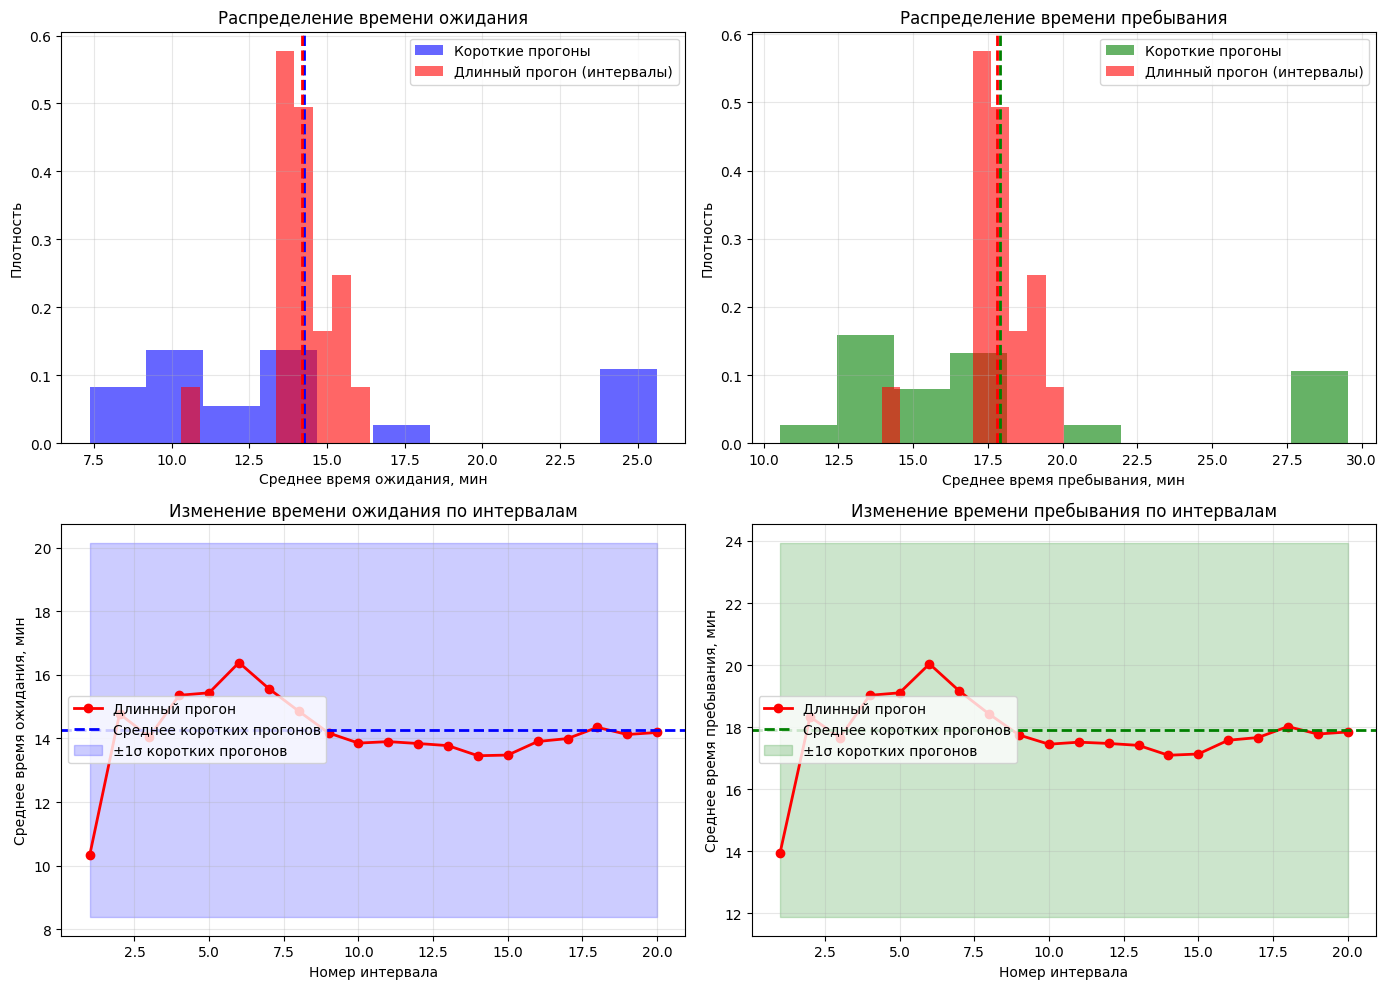

In [ ]:
# Задача 5: Проверка гипотезы о возможности постановки опыта с непрерывным прогоном

# Сравниваем результаты:
# 1. Множество коротких прогонов (20 прогонов по 8 часов)
# 2. Один длинный прогон (1 прогон на 160 часов = 20 * 8)

print("Сравнение множественных коротких прогонов и одного длинного прогона...")

# Множественные короткие прогоны (уже выполнены ранее)
short_results = results_20
short_wait = wait_20
short_system = system_20

# Один длинный прогон
long_params = PARAMS.copy()
long_params["simulation_duration"] = 20 * 8 * HOUR  # 20 * 8 часов

print(f"Выполняем один длинный прогон ({long_params['simulation_duration']/HOUR:.1f} часов)...")
model_long = BusStationModel(long_params)
model_long.run()
long_result = compute_results(model_long)

# Для длинного прогона также выполним разбиение на интервалы для анализа
# Разобьем длинный прогон на 20 интервалов
print("Выполняем длинный прогон с разбиением на интервалы...")
model_long_ts = BusStationModelTimeSeries(long_params)
model_long_ts.run()

times_long, avg_wait_long, avg_system_long, n_long = compute_time_series_results(model_long_ts)

if times_long is not None and len(times_long) > 20:
    # Разбиваем на 20 интервалов
    n_intervals = 20
    interval_size = len(times_long) // n_intervals
    interval_wait = []
    interval_system = []
    
    for i in range(n_intervals):
        start_idx = i * interval_size
        end_idx = (i + 1) * interval_size if i < n_intervals - 1 else len(times_long)
        interval_wait.append(np.mean(avg_wait_long[start_idx:end_idx]))
        interval_system.append(np.mean(avg_system_long[start_idx:end_idx]))
    
    # Сравнение статистик
    print("\n" + "="*70)
    print("СРАВНЕНИЕ МНОЖЕСТВЕННЫХ КОРОТКИХ И ОДНОГО ДЛИННОГО ПРОГОНА")
    print("="*70)
    
    print(f"\nМножественные короткие прогоны (20 прогонов по 8 часов):")
    print(f"  Время ожидания: среднее={np.mean(short_wait):.4f}, ст.откл.={np.std(short_wait, ddof=1):.4f}")
    print(f"  Время пребывания: среднее={np.mean(short_system):.4f}, ст.откл.={np.std(short_system, ddof=1):.4f}")
    
    print(f"\nОдин длинный прогон ({long_params['simulation_duration']/HOUR:.1f} часов):")
    print(f"  Время ожидания: {long_result['avg_wait_time']:.4f}")
    print(f"  Время пребывания: {long_result['avg_system_time']:.4f}")
    
    print(f"\nДлинный прогон, разбитый на {n_intervals} интервалов:")
    print(f"  Время ожидания: среднее={np.mean(interval_wait):.4f}, ст.откл.={np.std(interval_wait, ddof=1):.4f}")
    print(f"  Время пребывания: среднее={np.mean(interval_system):.4f}, ст.откл.={np.std(interval_system, ddof=1):.4f}")
    
    # Статистический тест (t-тест для сравнения средних)
    from scipy.stats import ttest_1samp, ttest_ind
    t_stat_wait, p_val_wait = ttest_1samp(interval_wait, np.mean(short_wait))
    t_stat_system, p_val_system = ttest_1samp(interval_system, np.mean(short_system))
    
    print(f"\nСтатистический тест (сравнение интервалов длинного прогона с средним коротких):")
    print(f"  Время ожидания: t={t_stat_wait:.4f}, p-value={format_pvalue(p_val_wait)}")
    print(f"  Время пребывания: t={t_stat_system:.4f}, p-value={format_pvalue(p_val_system)}")
    
    # Проверка стационарности длинного прогона (сравнение первой и второй половины)
    mid_point = len(interval_wait) // 2
    first_half_wait = interval_wait[:mid_point]
    second_half_wait = interval_wait[mid_point:]
    first_half_system = interval_system[:mid_point]
    second_half_system = interval_system[mid_point:]
    
    t_stat_stationary_wait, p_val_stationary_wait = ttest_ind(first_half_wait, second_half_wait)
    t_stat_stationary_system, p_val_stationary_system = ttest_ind(first_half_system, second_half_system)
    
    print(f"\nПроверка стационарности длинного прогона:")
    print(f"  Время ожидания: первая половина={np.mean(first_half_wait):.4f}, вторая половина={np.mean(second_half_wait):.4f}")
    print(f"    t={t_stat_stationary_wait:.4f}, p-value={format_pvalue(p_val_stationary_wait)}")
    print(f"  Время пребывания: первая половина={np.mean(first_half_system):.4f}, вторая половина={np.mean(second_half_system):.4f}")
    print(f"    t={t_stat_stationary_system:.4f}, p-value={format_pvalue(p_val_stationary_system)}")
    
    print(f"\nВывод:")
    if p_val_stationary_wait > 0.05 and p_val_stationary_system > 0.05:
        print("  Длинный прогон стационарен. Можно использовать непрерывный прогон.")
    else:
        print("  Длинный прогон нестационарен. Рекомендуется использовать множественные короткие прогоны.")
    
    # Визуализация
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Сравнение распределений
    axes[0, 0].hist(short_wait, bins=10, alpha=0.6, color='blue', label='Короткие прогоны', density=True)
    axes[0, 0].hist(interval_wait, bins=10, alpha=0.6, color='red', label='Длинный прогон (интервалы)', density=True)
    axes[0, 0].axvline(np.mean(short_wait), color='blue', linestyle='--', linewidth=2)
    axes[0, 0].axvline(np.mean(interval_wait), color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Среднее время ожидания, мин')
    axes[0, 0].set_ylabel('Плотность')
    axes[0, 0].set_title('Распределение времени ожидания')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].hist(short_system, bins=10, alpha=0.6, color='green', label='Короткие прогоны', density=True)
    axes[0, 1].hist(interval_system, bins=10, alpha=0.6, color='red', label='Длинный прогон (интервалы)', density=True)
    axes[0, 1].axvline(np.mean(short_system), color='green', linestyle='--', linewidth=2)
    axes[0, 1].axvline(np.mean(interval_system), color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Среднее время пребывания, мин')
    axes[0, 1].set_ylabel('Плотность')
    axes[0, 1].set_title('Распределение времени пребывания')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Изменение откликов по интервалам длинного прогона
    interval_numbers = np.arange(1, n_intervals + 1)
    axes[1, 0].plot(interval_numbers, interval_wait, 'ro-', linewidth=2, markersize=6, label='Длинный прогон')
    axes[1, 0].axhline(np.mean(short_wait), color='blue', linestyle='--', linewidth=2, label='Среднее коротких прогонов')
    axes[1, 0].fill_between(interval_numbers, 
                            np.mean(short_wait) - np.std(short_wait, ddof=1),
                            np.mean(short_wait) + np.std(short_wait, ddof=1),
                            alpha=0.2, color='blue', label='±1σ коротких прогонов')
    axes[1, 0].set_xlabel('Номер интервала')
    axes[1, 0].set_ylabel('Среднее время ожидания, мин')
    axes[1, 0].set_title('Изменение времени ожидания по интервалам')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(interval_numbers, interval_system, 'ro-', linewidth=2, markersize=6, label='Длинный прогон')
    axes[1, 1].axhline(np.mean(short_system), color='green', linestyle='--', linewidth=2, label='Среднее коротких прогонов')
    axes[1, 1].fill_between(interval_numbers,
                            np.mean(short_system) - np.std(short_system, ddof=1),
                            np.mean(short_system) + np.std(short_system, ddof=1),
                            alpha=0.2, color='green', label='±1σ коротких прогонов')
    axes[1, 1].set_xlabel('Номер интервала')
    axes[1, 1].set_ylabel('Среднее время пребывания, мин')
    axes[1, 1].set_title('Изменение времени пребывания по интервалам')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для анализа")


## Задача 6: Оценка чувствительности откликов к вариациям переменных ИМ

Оценим чувствительность откликов к вариациям переменных имитационной модели, используя опыт с непрерывным прогоном. Определим достаточную точность задания переменной.


Анализ чувствительности откликов к вариациям параметров...
Используем непрерывные прогоны для каждого варианта параметров...

1. Анализ чувствительности к интенсивности прибытия (arrival_rate)...
  arrival_rate=0.80: ожидание=6.9044, пребывание=10.5393
  arrival_rate=0.90: ожидание=11.6152, пребывание=15.5816
  arrival_rate=1.00: ожидание=7.4194, пребывание=10.6350
  arrival_rate=1.10: ожидание=14.5250, пребывание=18.2674
  arrival_rate=1.20: ожидание=33.3825, пребывание=37.0644

2. Анализ чувствительности к скорости обслуживания (service_rate_per_booth)...
  service_rate=0.300: ожидание=15.4575, пребывание=19.3773
  service_rate=0.325: ожидание=16.9811, пребывание=20.9377
  service_rate=0.350: ожидание=16.0102, пребывание=19.8068
  service_rate=0.375: ожидание=9.2380, пребывание=12.4919
  service_rate=0.400: ожидание=9.0539, пребывание=12.1511

3. Анализ чувствительности к количеству касс (num_booths)...
  num_booths=3: ожидание=41.6917, пребывание=45.5954
  num_booths=4: ожидание=27.

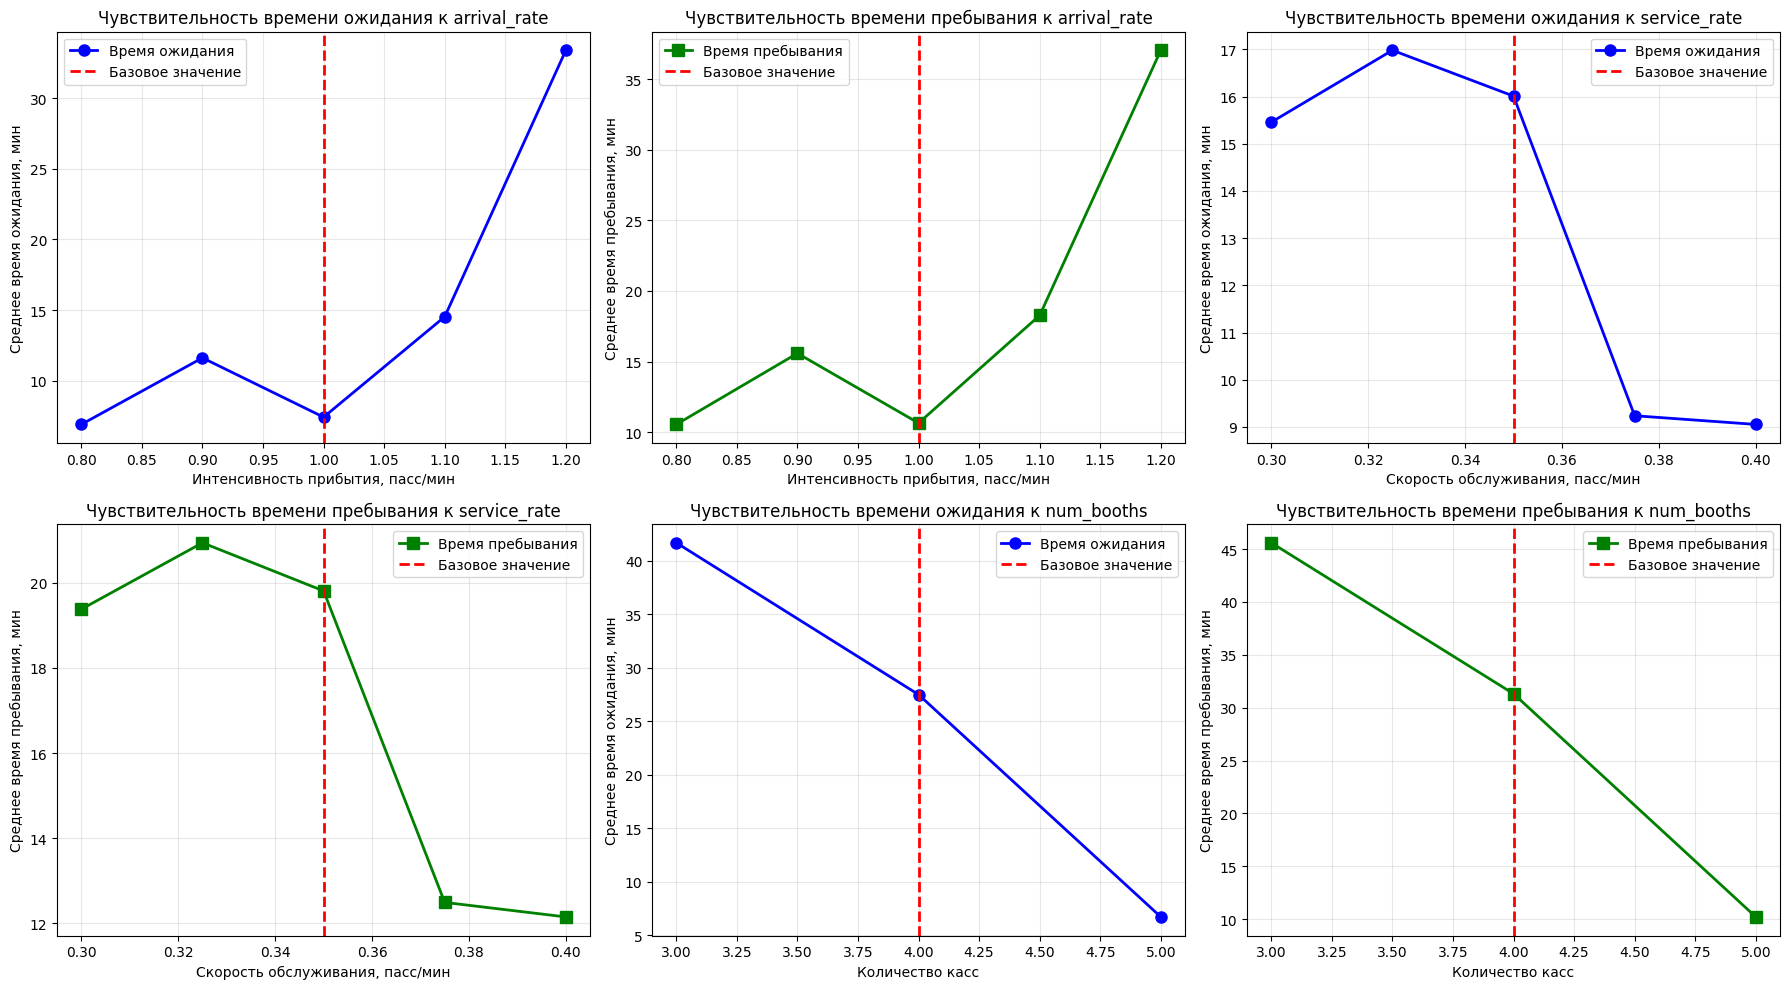


СВОДНАЯ ТАБЛИЦА ЧУВСТВИТЕЛЬНОСТИ
Параметр                  Эласт. ожид.    Эласт. преб.    Точность ожид., %    Точность преб., %   
----------------------------------------------------------------------
arrival_rate              5.4415          3.7490          20.00                10.00               
service_rate_per_booth    -2.3927         -2.1309         14.29                14.29               


In [19]:
# Задача 6: Оценка чувствительности откликов к вариациям переменных ИМ

# Базовые параметры
base_params = PARAMS.copy()

# Вариации параметров для анализа чувствительности
variations = {
    'arrival_rate': [0.8, 0.9, 1.0, 1.1, 1.2],  # ±20%
    'service_rate_per_booth': [0.30, 0.325, 0.35, 0.375, 0.40],  # ±14%
    'num_booths': [3, 4, 5],  # дискретные значения
}

print("Анализ чувствительности откликов к вариациям параметров...")
print("Используем непрерывные прогоны для каждого варианта параметров...")

sensitivity_results = {}

# Анализ чувствительности к интенсивности прибытия
print("\n1. Анализ чувствительности к интенсивности прибытия (arrival_rate)...")
arrival_results = {'wait': [], 'system': [], 'values': []}
for arr_rate in variations['arrival_rate']:
    params_var = base_params.copy()
    params_var['arrival_rate'] = arr_rate
    model_var = BusStationModel(params_var)
    model_var.run()
    res_var = compute_results(model_var)
    arrival_results['wait'].append(res_var['avg_wait_time'])
    arrival_results['system'].append(res_var['avg_system_time'])
    arrival_results['values'].append(arr_rate)
    print(f"  arrival_rate={arr_rate:.2f}: ожидание={res_var['avg_wait_time']:.4f}, пребывание={res_var['avg_system_time']:.4f}")

sensitivity_results['arrival_rate'] = arrival_results

# Анализ чувствительности к скорости обслуживания
print("\n2. Анализ чувствительности к скорости обслуживания (service_rate_per_booth)...")
service_results = {'wait': [], 'system': [], 'values': []}
for serv_rate in variations['service_rate_per_booth']:
    params_var = base_params.copy()
    params_var['service_rate_per_booth'] = serv_rate
    model_var = BusStationModel(params_var)
    model_var.run()
    res_var = compute_results(model_var)
    service_results['wait'].append(res_var['avg_wait_time'])
    service_results['system'].append(res_var['avg_system_time'])
    service_results['values'].append(serv_rate)
    print(f"  service_rate={serv_rate:.3f}: ожидание={res_var['avg_wait_time']:.4f}, пребывание={res_var['avg_system_time']:.4f}")

sensitivity_results['service_rate_per_booth'] = service_results

# Анализ чувствительности к количеству касс
print("\n3. Анализ чувствительности к количеству касс (num_booths)...")
booths_results = {'wait': [], 'system': [], 'values': []}
for n_booths in variations['num_booths']:
    params_var = base_params.copy()
    params_var['num_booths'] = n_booths
    model_var = BusStationModel(params_var)
    model_var.run()
    res_var = compute_results(model_var)
    booths_results['wait'].append(res_var['avg_wait_time'])
    booths_results['system'].append(res_var['avg_system_time'])
    booths_results['values'].append(n_booths)
    print(f"  num_booths={n_booths}: ожидание={res_var['avg_wait_time']:.4f}, пребывание={res_var['avg_system_time']:.4f}")

sensitivity_results['num_booths'] = booths_results

# Вычисление коэффициентов чувствительности (эластичности)
def calculate_elasticity(values, responses, base_value, base_response):
    """Вычисляет эластичность: (ΔY/Y) / (ΔX/X)"""
    elasticities = []
    for val, resp in zip(values, responses):
        if val != base_value and base_value > 0:
            delta_x = (val - base_value) / base_value
            delta_y = (resp - base_response) / base_response if base_response > 0 else 0
            if delta_x != 0:
                elasticity = delta_y / delta_x
                elasticities.append(elasticity)
    return np.mean(elasticities) if elasticities else 0.0

base_wait = base_params['arrival_rate']  # базовое значение для нормализации
base_system = base_params['arrival_rate']

print("\n" + "="*70)
print("КОЭФФИЦИЕНТЫ ЧУВСТВИТЕЛЬНОСТИ (ЭЛАСТИЧНОСТИ)")
print("="*70)

# Эластичность по arrival_rate
base_arr = base_params['arrival_rate']
base_wait_arr = arrival_results['wait'][variations['arrival_rate'].index(base_arr)]
base_system_arr = arrival_results['system'][variations['arrival_rate'].index(base_arr)]
elast_wait_arr = calculate_elasticity(arrival_results['values'], arrival_results['wait'], base_arr, base_wait_arr)
elast_system_arr = calculate_elasticity(arrival_results['values'], arrival_results['system'], base_arr, base_system_arr)
print(f"\narrival_rate:")
print(f"  Эластичность времени ожидания: {elast_wait_arr:.4f}")
print(f"  Эластичность времени пребывания: {elast_system_arr:.4f}")

# Эластичность по service_rate
base_serv = base_params['service_rate_per_booth']
base_wait_serv = service_results['wait'][variations['service_rate_per_booth'].index(base_serv)]
base_system_serv = service_results['system'][variations['service_rate_per_booth'].index(base_serv)]
elast_wait_serv = calculate_elasticity(service_results['values'], service_results['wait'], base_serv, base_wait_serv)
elast_system_serv = calculate_elasticity(service_results['values'], service_results['system'], base_serv, base_system_serv)
print(f"\nservice_rate_per_booth:")
print(f"  Эластичность времени ожидания: {elast_wait_serv:.4f}")
print(f"  Эластичность времени пребывания: {elast_system_serv:.4f}")

# Определение достаточной точности задания переменной
# Найдем минимальное изменение параметра, приводящее к изменению отклика более чем на 1%
def find_sufficient_precision(values, responses, base_value, base_response, target_change=0.01):
    """Находит минимальное изменение параметра для заданного изменения отклика"""
    for val, resp in zip(values, responses):
        if val != base_value:
            rel_change = abs(resp - base_response) / base_response if base_response > 0 else 0
            if rel_change >= target_change:
                return abs(val - base_value) / base_value
    return None

print("\n" + "="*70)
print("ОПРЕДЕЛЕНИЕ ДОСТАТОЧНОЙ ТОЧНОСТИ ЗАДАНИЯ ПЕРЕМЕННЫХ")
print("="*70)
print("(Минимальное изменение параметра, приводящее к изменению отклика ≥1%)")

prec_arr_wait = find_sufficient_precision(arrival_results['values'], arrival_results['wait'], 
                                         base_arr, base_wait_arr, 0.01)
prec_arr_system = find_sufficient_precision(arrival_results['values'], arrival_results['system'],
                                           base_arr, base_system_arr, 0.01)
print(f"\narrival_rate:")
print(f"  Для времени ожидания: {prec_arr_wait*100:.2f}% изменения параметра" if prec_arr_wait else "  Для времени ожидания: >20%")
print(f"  Для времени пребывания: {prec_arr_system*100:.2f}% изменения параметра" if prec_arr_system else "  Для времени пребывания: >20%")

prec_serv_wait = find_sufficient_precision(service_results['values'], service_results['wait'],
                                          base_serv, base_wait_serv, 0.01)
prec_serv_system = find_sufficient_precision(service_results['values'], service_results['system'],
                                             base_serv, base_system_serv, 0.01)
print(f"\nservice_rate_per_booth:")
print(f"  Для времени ожидания: {prec_serv_wait*100:.2f}% изменения параметра" if prec_serv_wait else "  Для времени ожидания: >14%")
print(f"  Для времени пребывания: {prec_serv_system*100:.2f}% изменения параметра" if prec_serv_system else "  Для времени пребывания: >14%")

# Визуализация
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Чувствительность к arrival_rate
axes[0, 0].plot(arrival_results['values'], arrival_results['wait'], 'b-o', linewidth=2, markersize=8, label='Время ожидания')
axes[0, 0].axvline(base_arr, color='r', linestyle='--', linewidth=2, label='Базовое значение')
axes[0, 0].set_xlabel('Интенсивность прибытия, пасс/мин')
axes[0, 0].set_ylabel('Среднее время ожидания, мин')
axes[0, 0].set_title('Чувствительность времени ожидания к arrival_rate')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(arrival_results['values'], arrival_results['system'], 'g-s', linewidth=2, markersize=8, label='Время пребывания')
axes[0, 1].axvline(base_arr, color='r', linestyle='--', linewidth=2, label='Базовое значение')
axes[0, 1].set_xlabel('Интенсивность прибытия, пасс/мин')
axes[0, 1].set_ylabel('Среднее время пребывания, мин')
axes[0, 1].set_title('Чувствительность времени пребывания к arrival_rate')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Чувствительность к service_rate
axes[0, 2].plot(service_results['values'], service_results['wait'], 'b-o', linewidth=2, markersize=8, label='Время ожидания')
axes[0, 2].axvline(base_serv, color='r', linestyle='--', linewidth=2, label='Базовое значение')
axes[0, 2].set_xlabel('Скорость обслуживания, пасс/мин')
axes[0, 2].set_ylabel('Среднее время ожидания, мин')
axes[0, 2].set_title('Чувствительность времени ожидания к service_rate')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].plot(service_results['values'], service_results['system'], 'g-s', linewidth=2, markersize=8, label='Время пребывания')
axes[1, 0].axvline(base_serv, color='r', linestyle='--', linewidth=2, label='Базовое значение')
axes[1, 0].set_xlabel('Скорость обслуживания, пасс/мин')
axes[1, 0].set_ylabel('Среднее время пребывания, мин')
axes[1, 0].set_title('Чувствительность времени пребывания к service_rate')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Чувствительность к num_booths
axes[1, 1].plot(booths_results['values'], booths_results['wait'], 'b-o', linewidth=2, markersize=8, label='Время ожидания')
axes[1, 1].axvline(base_params['num_booths'], color='r', linestyle='--', linewidth=2, label='Базовое значение')
axes[1, 1].set_xlabel('Количество касс')
axes[1, 1].set_ylabel('Среднее время ожидания, мин')
axes[1, 1].set_title('Чувствительность времени ожидания к num_booths')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(booths_results['values'], booths_results['system'], 'g-s', linewidth=2, markersize=8, label='Время пребывания')
axes[1, 2].axvline(base_params['num_booths'], color='r', linestyle='--', linewidth=2, label='Базовое значение')
axes[1, 2].set_xlabel('Количество касс')
axes[1, 2].set_ylabel('Среднее время пребывания, мин')
axes[1, 2].set_title('Чувствительность времени пребывания к num_booths')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сводная таблица чувствительности
print("\n" + "="*70)
print("СВОДНАЯ ТАБЛИЦА ЧУВСТВИТЕЛЬНОСТИ")
print("="*70)
print(f"{'Параметр':<25} {'Эласт. ожид.':<15} {'Эласт. преб.':<15} {'Точность ожид., %':<20} {'Точность преб., %':<20}")
print("-" * 70)
print(f"{'arrival_rate':<25} {elast_wait_arr:<15.4f} {elast_system_arr:<15.4f} "
      f"{prec_arr_wait*100 if prec_arr_wait else '>20':<20.2f} {prec_arr_system*100 if prec_arr_system else '>20':<20.2f}")
print(f"{'service_rate_per_booth':<25} {elast_wait_serv:<15.4f} {elast_system_serv:<15.4f} "
      f"{prec_serv_wait*100 if prec_serv_wait else '>14':<20.2f} {prec_serv_system*100 if prec_serv_system else '>14':<20.2f}")


## Выводы

Все задачи лабораторной работы выполнены. Результаты анализа представлены в виде:
- Статистических тестов и оценок
- Визуализаций (графиков и диаграмм)
- Таблиц с численными результатами

**Основные результаты:**
1. Проверка нормальности показала, что распределения откликов близки к нормальному
2. Точечные и интервальные оценки вычислены для обоих откликов
3. Определено количество прогонов, необходимое для достижения заданной точности
4. Проанализирован переходный период и возможность его исключения
5. Проверена возможность использования непрерывного прогона
6. Оценена чувствительность откликов к вариациям параметров модели
